## Setup

The set up phase of this notebook begins with mounting your google drive by running the first code chunk, the output will ask you to input an access token that can be found by clicking the provided link and signing into the google account associated with the current Colab session. This step allows you to save the doccano output somewhere in your drive without having to reupload the document every time you begin a new session (or the kernal restarts).

Once the drive is mounted, run the following code chunks IN THE ORDER THEY ARE PROVIDED. Failing to do so may cause errors do to potential conflicts between the `torch` and `transformer` libraries.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!curl -q https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
#!python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev



In [ ]:
import torch
torch.__version__

'1.10.0+cu111'

In [ ]:
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
import json
from collections import defaultdict, OrderedDict
import math
import numpy as np
import random

torch.manual_seed(1)

In [ ]:
!pip install transformers
!pip -q install seqeval

In [ ]:
from seqeval.metrics import classification_report as classification_report_seqeval
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

## Initialize GPU

In [ ]:
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dev

device(type='cuda', index=0)

## Load data

In [ ]:
# Read export file
## CHANGE THIS DIRECTORY TO WHERE THE DOCCANO TEST IS
with open('/content/drive/MyDrive/ML_Models/Bi-LSTM/doccano_output.jsonl', 'r') as f:
    lines = f.readlines()

len(lines)

108

In [ ]:
def remap(x: str):
    '''
    function for remapping labels from B-POS and I-POS to B-MISC and I-MISC
    '''
    if x == 'B-POS':
        return 'B-MISC'
    elif x == 'I-POS':
        return 'I-MISC'
    else:
        return x

In [ ]:
# The numerical doccano label to actual label (B-I-O scheme)

ix_to_label = {0: 'B-PER', 1: 'I-PER', 2:'B-MISC', 3:'I-MISC', 4:'B-ORG', 5: 'I-ORG', 6: 'O'}
    
# train/test data
data = []

# Vocabulary
vocab = set()
    
# Loop over each data point (a corpus of labeled text) to extract words
for line in lines:
    
    # An ordered dict will keep items in order for further manipulation
    # so we initialize here
    orddict = OrderedDict({})

    # Lists to hold the words and labels
    words = []
    labels = []
    # Convert line to json
    input_json = json.loads(line)
    annots = [[x[0], x[1], remap(x[2])] for x in input_json['label']] # call remap function to change token values for BERT-BASE-NER classification
    text = input_json['data']

    # Add each word annotation to OrderedDict
    for ann in annots:
        orddict[ann[0]] = ann
    
    # Sort ordered dict because there's no guarantee reading json
    # maintained order
    orddict = sorted(orddict.items(), key=lambda x: x[1][0])
    
    for item in orddict:
        # the item is a tuple where second value is the actual value we want
        ann = item[1]
        # Subset text string
        word = text[ann[0]:(ann[1])].rstrip()
        label = ann[2]
        # Add to list for this datum/corpus
        words.append(word)
        labels.append(label)
        vocab.add(word)
    # Add to overall data containers
    data.append((words, labels))

In [ ]:
ix_to_label =  {0: 'B-PER', 1: 'I-PER', 2:'B-MISC', 3:'I-MISC', 4:'B-ORG', 5: 'I-ORG', 6: 'O'}
tags_vals = [v for k,v in ix_to_label.items()]
tag2idx = {t: i for i, t in ix_to_label.items()}
sentences = [' '.join([s for s in sent[0]]) for sent in data]
labels = [[s for s in sent[1]] for sent in data]
labels = [[tag2idx.get(l) for l in lab] for lab in labels]

### BERT-BASE-NER

In [ ]:
# Defining tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

Downloading:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/829 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/413M [00:00<?, ?B/s]

In [ ]:
def label_entities(sequences):
    tokens_list = []
    labels_list = []
    for s in sequences:
        inputs = tokenizer(s, return_tensors = 'pt')
        tokens = inputs.tokens()

        outputs = model(**inputs).logits
        predictions = torch.argmax(outputs, dim=2)
        tokens_list.append(tokens)
        labels_list.extend([model.config.id2label[x] for x in predictions[0].numpy()])
    return tokens_list, labels_list


In [ ]:
# Pull lists of predicted tokens
tokens, pred_labels = label_entities(sentences)

# Map original tokens back to tag space
flat_labels = [tags_vals[l_i] if l_i is not None else 'O'  for l in labels for l_i in l]
pd.Series(flat_labels).value_counts()

O         2718
I-ORG      346
I-MISC     162
B-ORG      156
I-PER      120
B-PER      109
B-MISC      89
dtype: int64

### Comparing custom labels with new labels

Unfortunately, due to the sub-word tokenization techniques used in the BERT-BASE-NER model the number of tokens, and consequent number of labels, are going to be different. Therefore,, we cannot use the same `classification_report_seqeval` that we used in the BiLSTM-CRF and the fine-tuned bert-base-* models. An example of the differences between sequences can be seen in the second code chunk below.

In [ ]:
classification_report_seqeval([flat_labels], [pred_labels])

ValueError: ignored

Part of the reason for this difference in sample sizes is likely that the original data does not include the `[CLS]` and `[SEP]` identifiers that indicate the beginning and end of each sentence.

In [ ]:
print(data[1][0])
print(tokens[1])

['In', 'the', 'wake', 'of', 'nationwide', 'protests', 'about', 'racial', 'injustice', ',', 'we', 'partnered', 'with', 'CNN', 'to', 'air', 'a', 'town', 'hall', ',', 'Coming', 'Together', ':', 'Standing', 'Up', 'to', 'Racism', ',', 'and', 'launched', 'a', 'special', ',', 'The', 'Power', 'of', 'We', ',', 'on', 'PBS', 'Kids', 'and', 'HBO', 'Max']
['[CLS]', 'In', 'the', 'wake', 'of', 'nationwide', 'protests', 'about', 'racial', 'injustice', ',', 'we', 'partnered', 'with', 'CNN', 'to', 'air', 'a', 'town', 'hall', ',', 'Coming', 'Together', ':', 'Standing', 'Up', 'to', 'Ra', '##cis', '##m', ',', 'and', 'launched', 'a', 'special', ',', 'The', 'Power', 'of', 'We', ',', 'on', 'PBS', 'Kids', 'and', 'HBO', 'Max', '[SEP]']


### An alternative method of evaluation

Since the use of the NER pipeline includes a sub-word tokenizer that maps to a different number of outputs for each sequence, we are instead going to evaluate the distribution of entity types for both the handlabled tags and the tags returned by the huggingface pipeline.

Although this will serve to somewhat show differneces between the original tags and those assigned by the HuggingFace pipeline, there are a few remaining issues with this comparison. The primary issue is incomensurate tag-space, wherein the bert-base-ner incorporates an additional `'LOC'` set of tags indicating locations. Additionally, the reduction of the position category `'POS'` into a `'MISC'` category is not ideal, as the NER model may not regard the position of a person as a miscellaneous entity.

Nevertheless, we will look at a few key differences in the plots below to identify some advantages and disadvantages of the huggingface pipeline approach.

#### Distribution of Tags

The plot and value counts below demonstrate a similar *relative* prevalence of `'O'` tags to the others but, as expected with the differences in tokenization methods, the pipeline includes far more tag counts across all of the categories due to the use of sub-tokens.

Original Tag Counts: 
 B-MISC      89
B-ORG      156
B-PER      109
I-MISC     162
I-ORG      346
I-PER      120
O         2718
dtype: int64 

Pipeline Tag Counts: 
 B-LOC       19
B-MISC      39
B-ORG      197
B-PER      126
I-LOC       36
I-MISC      72
I-ORG      687
I-PER      166
O         3571
dtype: int64


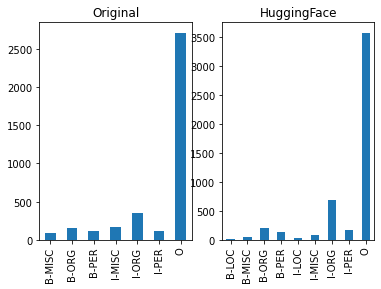

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2)

original_s = pd.Series(flat_labels)
predicted_s = pd.Series(pred_labels)

original_s.value_counts().sort_index().plot(kind = 'bar',title = 'Original', ax=axes[0])
predicted_s.value_counts().sort_index().plot(kind = 'bar',title = 'HuggingFace', ax=axes[1])

print("Original Tag Counts: \n", original_s.value_counts().sort_index(),  "\n\nPipeline Tag Counts: \n", predicted_s.value_counts().sort_index())

In the following plots, I remove the `'O'` tag to get a higher resolution view of the distibution between entities and evaluate their differences. One of the biggest differences is that the `ORG` tags are far more prevalent in the tagset provided by the hugging face pipeline than the original. Aside from that, it seems that the `PER` labels are relatively consistent and that the difference in counts is likely due to the subtokenization procedure.

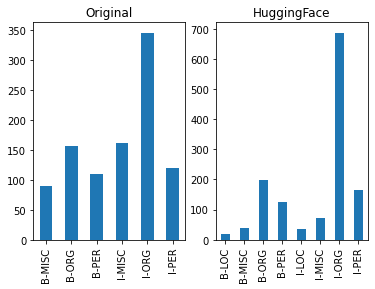

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2)

original_s.loc[original_s != 'O'].value_counts().sort_index().plot(kind = 'bar', title = 'Original', ax=axes[0])
predicted_s.loc[predicted_s != 'O'].value_counts().sort_index().plot(kind = 'bar', title = 'HuggingFace', ax=axes[1])

In [ ]:
stripped_original = original_s.loc[original_s != 'O'].apply(lambda x: x.split('-')[-1])
stripped_predicted = predicted_s.loc[predicted_s != 'O'].apply(lambda x: x.split('-')[-1])

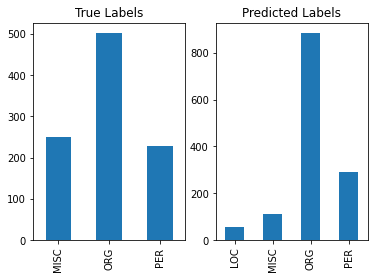

In [ ]:
original_s = pd.Series(flat_labels)
predicted_s = pd.Series(pred_labels)

stripped_original = original_s.loc[original_s != 'O'].apply(lambda x: x.split('-')[-1])
stripped_predicted = predicted_s.loc[predicted_s != 'O'].apply(lambda x: x.split('-')[-1])

fig, axes = plt.subplots(nrows=1, ncols=2)
stripped_original.value_counts().sort_index().plot(kind = 'bar', title = 'Original Labels', ax=axes[0])
stripped_predicted.value_counts().sort_index().plot(kind = 'bar', title = 'HuggingFace Labels', ax=axes[1])

# Sources 

HuggingFace Documentation https://huggingface.co/docs/transformers/master/en/task_summary#named-entity-recognition